# Analiza danych przejazdów autobusów ZTM

Importowanie bibliotek

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [16, 8]

### Instalowanie i importowanie własnej biblioteki

In [3]:
pip install ./spacial_data_analysis_ztm

Processing ./spacial_data_analysis_ztm
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for sda: filename=sda-0.7-py3-none-any.whl size=974 sha256=db0bcf8452cb5bcee69f4dd92193882082bfe7dd168256ad95f2fadae310d253
  Stored in directory: /tmp/pip-ephem-wheel-cache-re1yc7ig/wheels/44/a8/2d/1f34e57b9ec3e51c2a8a7002225360b392853a38f072a491a9
Successfully built sda
  Attempting uninstall: sda
    Found existing installation: sda 0.7
    Uninstalling sda-0.7:
      Successfully uninstalled sda-0.7
Note: you may need to restart the kernel to use updated packages.


In [4]:
import spacial_data_analysis_ztm

Ładowanie wcześniej ściągniętych danych zapisanych ze środka nocy 28.06.2021
Funkcja ta również usuwa duplikaty i konwertuje czas zapisany w ciągu znaków na pandas datetime

In [5]:
df_night = spacial_data_analysis_ztm.load_files_directory_into_df('data/28.06.2021_night_minute')

data/28.06.2021_night_minute
FInished importing files


In [6]:
df_night = df_night.drop(columns = ['Unnamed: 0'])

Konwertowanie Lon i Lat (długość i szerokość geograficzna) z DataFrame na typ POINT w GeoDataFrame (rozbudowane DataFrame z biblioteki Geopandas).

In [7]:
# oryginalny CRS ze strony ztm crs='EPSG:4326'
ztm_crs = 'EPSG:4326'
gdf_night = spacial_data_analysis_ztm.covert_long_lat_into_geodataframe(df_night, ztm_crs)

Sprawdzanie czy dane zostały załadowanie

In [8]:
gdf_night.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,geometry
0,213,21.115615,1000,2021-06-27 23:51:33,52.234600,2,POINT (21.11562 52.23460)
1,213,21.115168,1001,2021-06-28 00:30:59,52.234600,3,POINT (21.11517 52.23460)
2,213,21.114898,1003,2021-06-27 00:02:20,52.234726,1,POINT (21.11490 52.23473)
3,213,21.115269,1005,2021-06-27 23:19:40,52.234594,4,POINT (21.11527 52.23459)
4,130,21.115590,1008,2021-06-25 20:19:05,52.234613,04,POINT (21.11559 52.23461)


Konwertowanie zapisu przestrzennego z CRS na projected CRS (potrzebne do obliczania odległości)

In [9]:
gdf_night = gdf_night.to_crs(epsg=2178)

In [10]:
gdf_night.crs

<Projected CRS: EPSG:2178>
Name: ETRS89 / Poland CS2000 zone 7
Axis Info [cartesian]:
- x[north]: Northing (metre)
- y[east]: Easting (metre)
Area of Use:
- name: Poland - onshore and offshore between 19°30'E and 22°30'E.
- bounds: (19.5, 49.09, 22.5, 54.55)
Coordinate Operation:
- name: Poland CS2000 zone 7
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich


Sortowanie GeoDataFrame ze względu na kolumny VehicleNumber i Time

In [11]:
gdf_night = spacial_data_analysis_ztm.sort_vehicle_number_time(gdf_night)

Usuwanie duplikatów bazując na bazując na VehicleNumber i Time

In [12]:
gdf_night = spacial_data_analysis_ztm.remove_duplicates(gdf_night)

Usuwanie tych pojazdów (vehlcle), które występują tylko jeden raz (nie da na nich nic policzyć; często jest to jakaś pozostałość, która zostaje w danych)

In [13]:
gdf_night = spacial_data_analysis_ztm.remove_vehicles_one_occurrence(gdf_night)

Kalkulowanie dystansu pomiędzy punktami (POINT) w kolumnie geometry, oraz obliczanie różnic czasu na podstawie kolumny Time (TIMEDELTAS)

Uwaga. Może zając kokoło minuty, im większe dane tym dłużej.

In [14]:
gdf_night = spacial_data_analysis_ztm.calculate_distance_timedelta(gdf_night)

[......................................................]

In [15]:
len(gdf_night)

8193

Sprawdzanie pierwszych kilku wierszy

In [16]:
gdf_night['distance']

326             NaN
829        2.709341
1332       4.074632
1833       4.180773
2335       1.511374
            ...    
30809    743.066151
31247    457.598586
31686    348.151915
32125    509.039878
32565    239.490037
Name: distance, Length: 8193, dtype: float64

Kalkulowanie metrów na sekundę - dzielenie metrów na różnicę w czasie (timedeltas)

In [17]:
gdf_night = spacial_data_analysis_ztm.calculate_mpers(gdf_night)

In [18]:
gdf_night.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,geometry,distance,TimeDelta,seconds,speed_m/s,speed_km_h
326,150,20.864546,776,2021-06-28 00:44:21,52.360001,,POINT (7490772.809 5802962.913),NaN,NaT,NaN,NaN,NaN
829,150,20.864511,776,2021-06-28 00:45:18,52.359990,,POINT (7490770.395 5802961.683),2.709341,0 days 00:00:57,57.0,0.047532,0.171116
1332,150,20.864550,776,2021-06-28 00:46:13,52.360017,,POINT (7490773.091 5802964.738),4.074632,0 days 00:00:55,55.0,0.074084,0.266703
1833,150,20.864516,776,2021-06-28 00:47:17,52.359986,,POINT (7490770.755 5802961.270),4.180773,0 days 00:01:04,64.0,0.065325,0.235168
2335,150,20.864538,776,2021-06-28 00:48:15,52.359985,,POINT (7490772.260 5802961.134),1.511374,0 days 00:00:58,58.0,0.026058,0.093809


## Dane z dnia
Ładowanie wcześniej ściągniętych danych zapisanych z dnia 28.06.2021.
Powtarzanie całego powyższego procesu dla danych z dnia (w przeciwieństwie do nocy).

In [19]:
df_day = spacial_data_analysis_ztm.load_files_directory_into_df('data/28.06.2021_day_minute')

data/28.06.2021_day_minute
FInished importing files


Konwertowanie Lon i Lat (długość i szerokość geograficzna) z DataFrame na typ POINT w GeoDataFrame (rozbudowane DataFrame z biblioteki Geopandas).

In [20]:
df_day = df_day.drop(columns = ['Unnamed: 0'])

In [21]:
gdf_day = spacial_data_analysis_ztm.covert_long_lat_into_geodataframe(df_day, ztm_crs)

Sprawdzanie czy dane zostały załadowanie

In [22]:
gdf_day.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,geometry
0,213,21.203191,1001,2021-06-28 16:07:22,52.159396,1,POINT (21.20319 52.15940)
1,213,21.212667,1003,2021-06-28 16:07:18,52.161133,05,POINT (21.21267 52.16113)
2,213,21.102286,1004,2021-06-28 16:07:15,52.222845,3,POINT (21.10229 52.22285)
3,196,21.177343,1005,2021-06-28 16:07:18,52.256837,2,POINT (21.17734 52.25684)
4,196,21.176384,1008,2021-06-28 16:07:14,52.256761,03,POINT (21.17638 52.25676)


Konwertowanie zapisu przestrzennego z CRS na projected CRS (potrzebne do obliczania odległości)

In [23]:
gdf_day = gdf_day.to_crs(epsg=2178)

In [24]:
gdf_day.crs

<Projected CRS: EPSG:2178>
Name: ETRS89 / Poland CS2000 zone 7
Axis Info [cartesian]:
- x[north]: Northing (metre)
- y[east]: Easting (metre)
Area of Use:
- name: Poland - onshore and offshore between 19°30'E and 22°30'E.
- bounds: (19.5, 49.09, 22.5, 54.55)
Coordinate Operation:
- name: Poland CS2000 zone 7
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich


Sortowanie GeoDataFrame ze względu na kolumny VehicleNumber i Time

In [25]:
gdf_day = spacial_data_analysis_ztm.sort_vehicle_number_time(gdf_day)

Usuwanie duplikotów bazując na bazując na VehicleNumber i Time

In [26]:
gdf_day = spacial_data_analysis_ztm.remove_duplicates(gdf_day)

Usuwanie tych pojazdów (vehlcle), które występują tylko jeden raz (nie da się nic policzyć; często jest to jakaś pozostałość, która zostaje w danych)

In [27]:
gdf_day = spacial_data_analysis_ztm.remove_vehicles_one_occurrence(gdf_day)

Kalkulowanie dystansu pomiędzy punktami (POINT) w kolumnie geometry, oraz obliczanie różnic czasu na podstawie kolumny Time (TIMEDELTAS)

!Może zająć wiele czasu.
dla danych day_minute - 1-3 minuty;
dla danych day do 10 minut

In [28]:
gdf_day = spacial_data_analysis_ztm.calculate_distance_timedelta(gdf_day)

[...................................................]

In [29]:
len(gdf_day)

112137

Sprawdzanie pierwszych kilku wierszy

In [30]:
gdf_day.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,geometry,distance,TimeDelta
805,110,20.968691,742,2021-06-28 16:07:21,52.272133,1,POINT (7497862.988 5793178.124),NaN,NaT
2276,110,20.968685,742,2021-06-28 16:08:17,52.272137,1,POINT (7497862.578 5793178.570),0.604808,0 days 00:00:56
3753,110,20.968588,742,2021-06-28 16:11:21,52.272190,1,POINT (7497855.960 5793184.469),8.866186,0 days 00:03:04
5227,110,20.968618,742,2021-06-28 16:14:25,52.272160,1,POINT (7497858.006 5793181.131),3.915946,0 days 00:03:04
6703,110,20.968636,742,2021-06-28 16:17:29,52.272190,1,POINT (7497859.236 5793184.468),3.556846,0 days 00:03:04


Kalkulowanie metrów na sekundę - dzielenie metrów na różnicę w czasie (timedeltas)

In [31]:
gdf_day = spacial_data_analysis_ztm.calculate_mpers(gdf_day)

In [32]:
gdf_day.head()

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,geometry,distance,TimeDelta,seconds,speed_m/s,speed_km_h
805,110,20.968691,742,2021-06-28 16:07:21,52.272133,1,POINT (7497862.988 5793178.124),NaN,NaT,NaN,NaN,NaN
2276,110,20.968685,742,2021-06-28 16:08:17,52.272137,1,POINT (7497862.578 5793178.570),0.604808,0 days 00:00:56,56.0,0.010800,0.038880
3753,110,20.968588,742,2021-06-28 16:11:21,52.272190,1,POINT (7497855.960 5793184.469),8.866186,0 days 00:03:04,184.0,0.048186,0.173469
5227,110,20.968618,742,2021-06-28 16:14:25,52.272160,1,POINT (7497858.006 5793181.131),3.915946,0 days 00:03:04,184.0,0.021282,0.076616
6703,110,20.968636,742,2021-06-28 16:17:29,52.272190,1,POINT (7497859.236 5793184.468),3.556846,0 days 00:03:04,184.0,0.019331,0.069590


### Ładowanie mapy Warszawy z dzielnicami

Dane ze strony:
https://github.com/andilabs/warszawa-dzielnice-geojson/
Ściągnięte też do data/warsaw

In [33]:
# dane ze strony
#warsaw_file = "https://raw.githubusercontent.com/andilabs/warszawa-dzielnice-geojson/master/warszawa-dzielnice.geojson"

# dane z pliku w katalogu data/warsaw
warsaw_file = "data/warsaw/warszawa-dzielnice.geojson"

In [34]:
warsaw = gpd.read_file(warsaw_file)

In [35]:
# usuwanie całej Warszawy (zostają dzielnice)
warsaw = warsaw.iloc[1:]

Konwertowanie zapisu przestrzennego z CRS na projected CRS

In [36]:
projected_crs_poland = 'epsg:2178'

In [37]:
warsaw = warsaw.to_crs(projected_crs_poland)

#### Usuwanie prędkości zbyt dużych które muszą wynikać z błędów w danych

Widać, że pewne prędkości są kompletnie błędne, wynika to z błędu w danych z api.

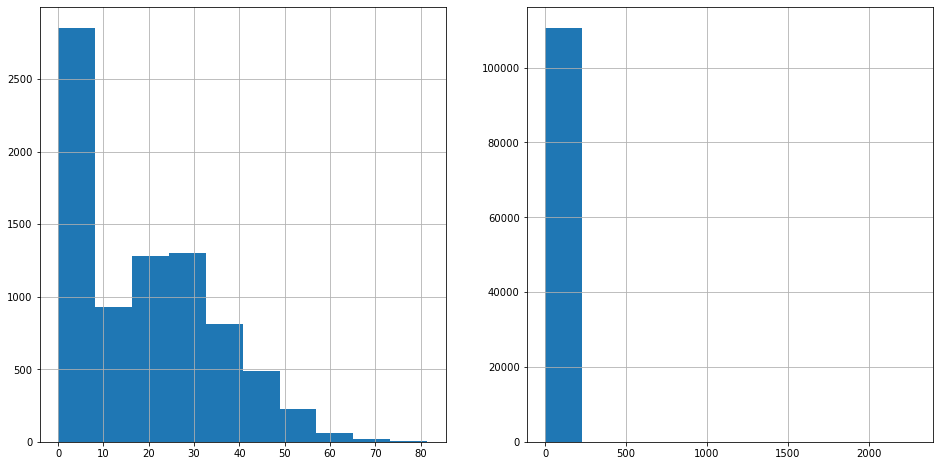

In [38]:
fix, (ax1, ax2) = plt.subplots(ncols=2) 

gdf_night['speed_km_h'].hist(ax=ax1)
gdf_day['speed_km_h'].hist(ax=ax2)

_ = plt.plot()

In [39]:
# fix, (ax1, ax2) = plt.subplots(ncols=2) 

# gdf_night['speed_km_h'].plot(ax=ax1)
# gdf_day['speed_km_h'].plot(ax=ax2)
# _ = plt.plot()

In [40]:
gdf_day = spacial_data_analysis_ztm.remove_vehicle_extreme_speed(gdf_day, 110)

Removing following VehicleNumbers from the DataFrame:  [1907, 3423, 7226, 8806, 9825]


In [41]:
gdf_night = spacial_data_analysis_ztm.remove_vehicle_extreme_speed(gdf_night, 110)

Removing following VehicleNumbers from the DataFrame:  []


Po usunięciu tych danych rozkłady powinny wyglądać "normalnie".

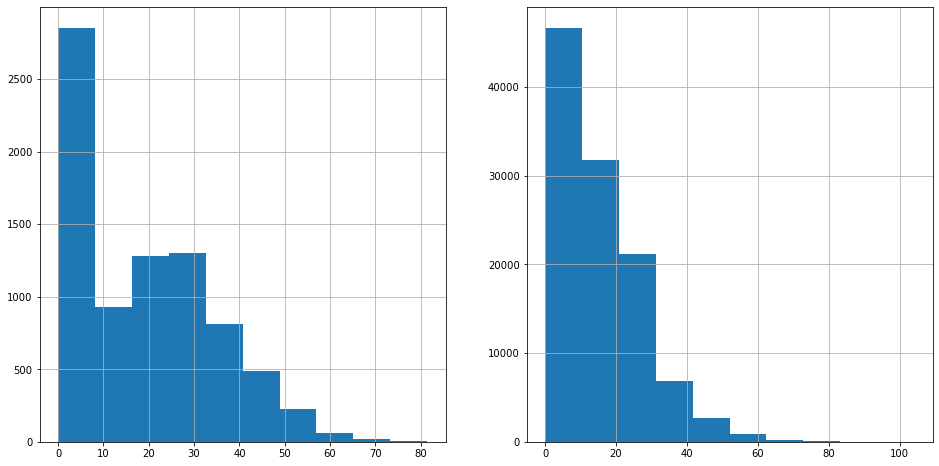

In [42]:
fix, (ax1, ax2) = plt.subplots(ncols=2) 

gdf_night['speed_km_h'].hist(ax=ax1)
gdf_day['speed_km_h'].hist(ax=ax2)

_ = plt.plot()

#### Resetowanie indeksów

Z usunięciem starego indeksu

In [43]:
gdf_night = gdf_night.reset_index(drop=True)

In [44]:
gdf_day = gdf_day.reset_index(drop=True)

#### Obliczanie na podstawie wartości POINT, do której dzielnicy należy dany punkt i dodawanie tej dzielnicy do kolumny District.

In [45]:
# https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff
for i in warsaw.index:
    pip = gdf_night.within(warsaw.loc[i, 'geometry'])
    gdf_night.loc[pip, 'District'] = warsaw.loc[i, 'name']

In [46]:
# https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff
for i in warsaw.index:
    pip = gdf_day.within(warsaw.loc[i, 'geometry'])
    gdf_day.loc[pip, 'District'] = warsaw.loc[i, 'name']

In [47]:
gdf_night

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,geometry,distance,TimeDelta,seconds,speed_m/s,speed_km_h,District
0,150,20.864546,776,2021-06-28 00:44:21,52.360001,,POINT (7490772.809 5802962.913),NaN,NaT,NaN,NaN,NaN,NaN
1,150,20.864511,776,2021-06-28 00:45:18,52.359990,,POINT (7490770.395 5802961.683),2.709341,0 days 00:00:57,57.0,0.047532,0.171116,NaN
2,150,20.864550,776,2021-06-28 00:46:13,52.360017,,POINT (7490773.091 5802964.738),4.074632,0 days 00:00:55,55.0,0.074084,0.266703,NaN
3,150,20.864516,776,2021-06-28 00:47:17,52.359986,,POINT (7490770.755 5802961.270),4.180773,0 days 00:01:04,64.0,0.065325,0.235168,NaN
4,150,20.864538,776,2021-06-28 00:48:15,52.359985,,POINT (7490772.260 5802961.134),1.511374,0 days 00:00:58,58.0,0.026058,0.093809,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8188,N43,20.959797,9929,2021-06-28 01:47:40,52.219547,3,POINT (7497252.677 5787327.524),743.066151,0 days 00:01:06,66.0,11.258578,40.530881,Wola
8189,N43,20.962139,9929,2021-06-28 01:48:35,52.215694,3,POINT (7497412.497 5786898.742),457.598586,0 days 00:00:55,55.0,8.319974,29.951907,Ochota
8190,N43,20.966814,9929,2021-06-28 01:49:27,52.214451,3,POINT (7497731.933 5786760.286),348.151915,0 days 00:00:52,52.0,6.695229,24.102825,Ochota
8191,N43,20.973288,9929,2021-06-28 01:50:22,52.212189,3,POINT (7498174.300 5786508.427),509.039878,0 days 00:00:55,55.0,9.255271,33.318974,Ochota


### Mapa Warszawy

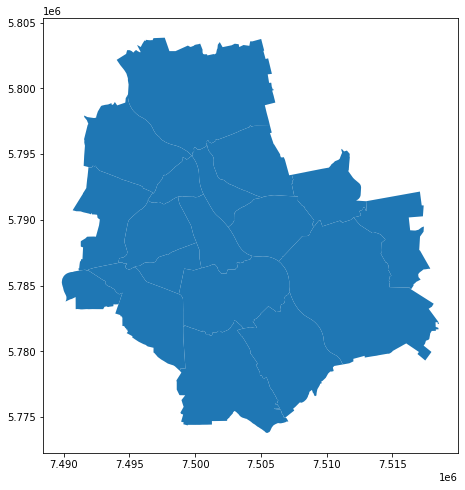

In [48]:
_ = warsaw.plot()

##### Mapa z miejscami gdzie przekraczana jest prędkość
czerwony noc

pomarańczowy dzień

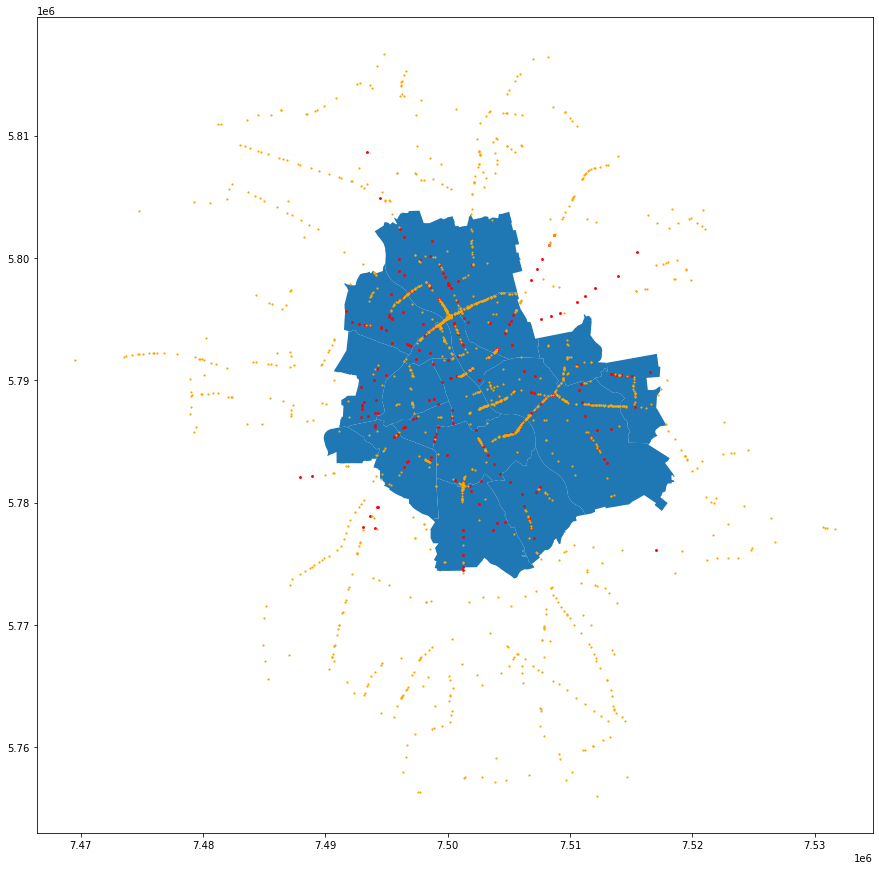

In [49]:
plt.rcParams['figure.figsize'] = [30, 15]
fig, ax = plt.subplots()
# ax.get_legend().remove()
warsaw.plot(ax=ax, legend=False)
gdf_night[gdf_night.speed_km_h > 50].plot(ax=ax, color='red', markersize=3.4, legend=False)
gdf_day[gdf_day.speed_km_h > 50].plot(ax=ax, color='orange', markersize=1.4, legend=False)
plt.plot(legend=False)
plt.rcParams['figure.figsize'] = [16, 8]

###### Porównanie najwiekszej prędkości i średniej prędkości (dla wszystkich autobusów) z dnia i tych samych wartości z nocy.

In [50]:
# noc
speed_max_night = gdf_night['speed_km_h'].max()
# dzień
speed_max_day = gdf_day['speed_km_h'].max()
av_speed_night = gdf_night['speed_km_h'].mean()
av_speed_day = gdf_day['speed_km_h'].mean()

<Figure size 720x360 with 0 Axes>

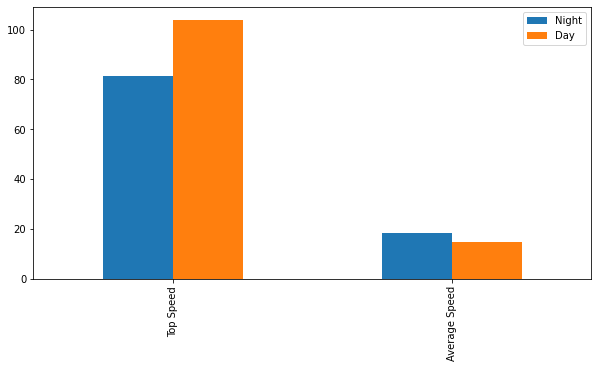

In [51]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.tight_layout()
index = ['Top Speed', 'Average Speed']
df_sp_av = pd.DataFrame({'Night': [speed_max_night, av_speed_night], 'Day': [speed_max_day, av_speed_day]}, index=index)
_ = df_sp_av.plot.bar()

#### Procent pomiarów prędkości pojazdów powyżej 50 km/h

In [52]:
speeding_vehicles_night = spacial_data_analysis_ztm.return_vehicles_above_speed(gdf_night, 50)

In [53]:
speeding_vehicles_day = spacial_data_analysis_ztm.return_vehicles_above_speed(gdf_day, 50)

In [54]:
speeding_vehicles_night

49.43181818181818

In [55]:
speeding_vehicles_day

39.052848318462594

<Figure size 720x360 with 0 Axes>

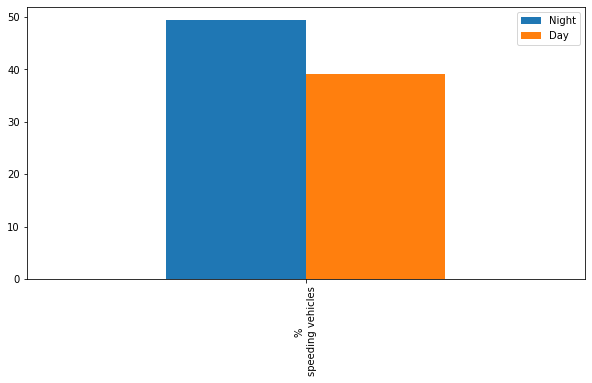

In [56]:
plt.rcParams['figure.figsize'] = [10, 5]
index = ['% \nspeeding vehicles']
plt.tight_layout()
df_sp_perc = pd.DataFrame({'Night': [speeding_vehicles_night], 'Day': [speeding_vehicles_day]}, index=index)
_ = df_sp_perc.plot.bar()

### Sortowanie czy sprawdzanie czy w której autobus jest dzielnicy (albo czy jest poza Warszawą)

Znajdowanie największych wartości prędkości speed_km_h pod względem dzielnic i pojazdów.

konwertowanie series z poprzedniego kroku na DataFrame.

Konwersja 'District' z  indeksu na kolumnę.

Aplikowanie maski na prędkość, a potem zwracanie liczby wystąpień dla poszczególnych dzielnic.


In [57]:
districts_speeding_night = spacial_data_analysis_ztm.speeding_by_district(gdf_night)
districts_speeding_day = spacial_data_analysis_ztm.speeding_by_district(gdf_day)

In [58]:
extra = set(districts_speeding_day.index) ^ set(districts_speeding_night.index)

In [59]:
if (len(districts_speeding_day.index) > len(districts_speeding_night.index)):
    for e in extra:
        districts_speeding_night[e] = 0
elif (len(districts_speeding_day.index) < len(districts_speeding_night.index)):
    for e in extra:
        districts_speeding_day[e] = 0
#         pd.concat(districts_speeding_night, {e: 0})

In [60]:
speeding_df = pd.DataFrame([districts_speeding_day, districts_speeding_night], index=['Day', 'Night'])

<Figure size 720x360 with 0 Axes>

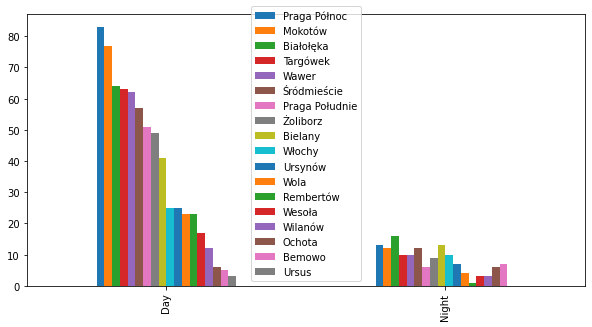

In [61]:
plt.tight_layout()
_ = speeding_df.plot.bar()

W następujących dzielnicach więcej niż 5 pojazdów przekracza prędkość.

Odpowiednio dla nocy i dnia.

In [62]:
districts_speeding_night[districts_speeding_night > 5]

Białołęka         16
Praga Północ      13
Bielany           13
Śródmieście       12
Mokotów           12
Targówek          10
Wawer             10
Włochy            10
Żoliborz           9
Bemowo             7
Ursynów            7
Praga Południe     6
Ochota             6
Name: District, dtype: int64

In [63]:
districts_speeding_day[districts_speeding_day > 5]

Praga Północ      83
Mokotów           77
Białołęka         64
Targówek          63
Wawer             62
Śródmieście       57
Praga Południe    51
Żoliborz          49
Bielany           41
Włochy            25
Ursynów           25
Wola              23
Rembertów         23
Wesoła            17
Wilanów           12
Ochota             6
Name: District, dtype: int64

#### Przekroczone prędkości nałożone na mapy


In [64]:
dis = districts_speeding_night.idxmax(axis=0, skipna=True)

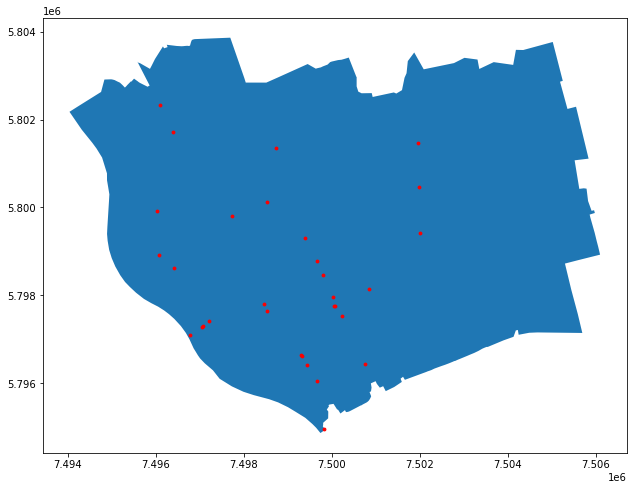

In [65]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
warsaw[warsaw['name'] == dis].plot(ax=ax, label=dis, legend=False)
gdf_night[(gdf_night.speed_km_h > 50) & (gdf_night.District == dis)].plot(ax=ax, color='red', markersize=8, legend=False)
_ = plt.plot(legend=False)

In [66]:
dis = districts_speeding_day.idxmax(axis=0, skipna=True)

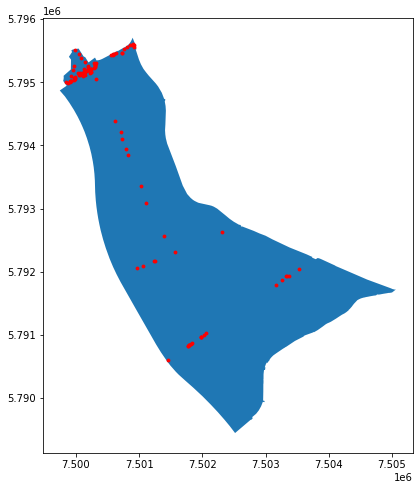

In [67]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
warsaw[warsaw['name'] == dis].plot(ax=ax, label=dis, legend=False)
gdf_day[(gdf_day.speed_km_h > 50) & (gdf_day.District == dis)].plot(ax=ax, color='red', markersize=8, legend=False)
_ = plt.plot(legend=False)

Tutaj widać, że zdecydowana większość przekroczeń prędkości była na S8, co może oznaczać, że prędkość w sensie prawnym, nie była przekroczona.